# 1. Introduction

**Background for Part 1:** This python notebook is the second part of my Financial Crypto App Project in which I generated synthetic, artificial data that resemble actual user and transaction data from a financial app or digital wallet. The key objective in the previous notebook was to simulate changes in two different timeframes after the introduction of a series of application modules in a hypothetical app whose aim was a system upgrade. The two dataframes are entitled "df_pre_mod" to refer to the pre-module dataframe and "df_post_mod" for the post-module dataframe. Please refer to my previous python notebook for more information entitled "Artificially Generated Financial Crypto Datasets".

**Main Objective:** The key objective of this notebook is to provide the methodology on how to statistically assess differences between the two timeframes (before and after the modules were introduced to our hypothetical app).

**Secondary Objective:** Prior to employing any statistical test, provide a realistic example of EDA (exploratory data analysis) on how we can spot any inconistencies, anomalous usage or data patterns.

**Variables/Columns:** I have chosen the following variables/columns to be present in each dataset:
- trade_id: shows the transaction ID, it a unique column that can also function as a unique identifier in SQL databases if needed
- user_id: shows the user ID, there must be several similar user IDs in the each dataset but also in-between datasets, but also allow several hypothetical users to "leave" the app after the modules have been introduced to simulate more realistic data
- conf_date: stands for Confirmation Date, which is the date of confirmation for the initial transaction
- leg 1 and 2 (type, amount, conf_status): Leg One and Leg Two are standard terms in financial apps and stand for the initial and secondary transaction process in the app. Leg_1_type illustrates the type of cryptocurrency (i.e. name), leg_1_amount illustrates the amount of each crypto traded/invested, leg_1_conf_status illustrates the outcomes of the transaction (I have choosen three to be featured: confirmed, pending, declined). Similar options must exist for the leg_2 variable.    

# 2. Exploratory Data Analysis

In [38]:
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import random
import string
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tabulate import tabulate
import pandas as pd
import numpy as np

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_pre_mod = pd.read_csv('C:/path.../df_pre_mod.csv')
df_post_mod = pd.read_csv('C:/path.../df_post_mod.csv')

In [10]:
df_pre_mod.head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status
0,641OKk454dVpm,960tveyimat,2022-01-03,Ethereum Classic,124.19,pending,Illuvium,Unknown,pending
1,998INa6jZZi1V,960tveyimat,2022-03-23,IOTA,67.69,pending,Neo,Unknown,pending
2,534VKk0D7QNdU,960tveyimat,2022-06-03,Ethereum Classic,14.55,pending,LINK,Unknown,pending


In [11]:
df_post_mod.head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status
0,723caaXA0YO7c,811rbsjbfvi,2022-08-27,GMX,64.37,confirmed,GateToken,Unknown,confirmed
1,703OgOAauuRk5,811rbsjbfvi,2022-10-25,Solana,91.48,confirmed,Bitcoin SV,Unknown,confirmed
2,909tUGkUOeulV,811rbsjbfvi,2022-09-29,Solana,274.81,pending,Gnosis,Unknown,pending


## 2.1 Addressing Confirmation Status


Getting a deeper understand each dataset is an important aspect that we need to address in every pre-processing and feature engineering section. For this particular dataset it is important to note that certain transactions that have been succesfully initiated might not be succesfully completed. This is reflected in the confirmation status of two key variables: [leg_1_conf_status] and [leg_2_conf_status].

There are three possible choices for each confirmation status variable:

In [13]:
print(f"Initial confirmation status (leg_1) options:\n {np.unique(df_pre_mod['leg_1_conf_status'])}")
print(f"\nSecondary confirmation status (leg_2) options:\n {np.unique(df_pre_mod['leg_2_conf_status'])}")

Initial confirmation status (leg_1) options:
 ['confirmed' 'declined' 'pending']

Secondary confirmation status (leg_2) options:
 ['confirmed' 'declined' 'pending']


The leg_1 variable relates to the initial action of a trade, contract, transcation between two parties (the purchase of a crypto-currency in our example) and leg_2 refers to the second part of said transaction (e.g a currency swap).

In our dataset it appears that while we have an overwhelming majority of leg_1 'confirmed' statuses, we also have a not insignificant amount of 'pending' and 'declined' statuses.

Let us ascertain the nature of the 'pending' and 'declined' transactions to get to the bottom of this issue.

## 2.2 Pre-Module Confirmation Status

In [16]:
# standard value counts
leg_1_conf_status_counts = df_pre_mod['leg_1_conf_status'].value_counts()
leg_2_conf_status_counts = df_pre_mod['leg_2_conf_status'].value_counts()

# value counts as percentages
leg_1_conf_status_perc = (leg_1_conf_status_counts / leg_1_conf_status_counts.sum() * 100).round(2)
leg_2_conf_status_perc = (df_pre_mod["leg_2_conf_status"].value_counts(normalize=True) * 100).round(2)

# Combining into a single table
combined_table = pd.concat([leg_1_conf_status_counts, leg_1_conf_status_perc, leg_2_conf_status_counts, leg_2_conf_status_perc], axis=1)

# Renaming columns
combined_table.columns = ['Standard Counts(leg1)', '%Percentage(leg1)', 'Standard Counts(leg2)', '%Percentage(leg2)']

# Reset index and set confirmation status as a separate column
combined_table = combined_table.reset_index().rename(columns={'index':'Confirmation Status'})

# Printing tabulated table
print("\nTable A: Pre-Module Standard Value Counts and Percentages of leg_1 and leg_2 confirmation status")
print(tabulate(combined_table, headers='keys', tablefmt='psql', showindex=False))


Table A: Pre-Module Standard Value Counts and Percentages of leg_1 and leg_2 confirmation status
+-----------------------+-------------------------+---------------------+-------------------------+---------------------+
| Confirmation Status   |   Standard Counts(leg1) |   %Percentage(leg1) |   Standard Counts(leg2) |   %Percentage(leg2) |
|-----------------------+-------------------------+---------------------+-------------------------+---------------------|
| confirmed             |                     807 |               85.94 |                     718 |               76.46 |
| pending               |                      92 |                9.8  |                     162 |               17.25 |
| declined              |                      40 |                4.26 |                      59 |                6.28 |
+-----------------------+-------------------------+---------------------+-------------------------+---------------------+


## 2.2 Post-Module Confirmation Status

In [17]:
# standard value counts
leg_1_conf_status_counts = df_post_mod['leg_1_conf_status'].value_counts()
leg_2_conf_status_counts = df_post_mod['leg_2_conf_status'].value_counts()

# value counts as percentages
leg_1_conf_status_perc = (leg_1_conf_status_counts / leg_1_conf_status_counts.sum() * 100).round(2)
leg_2_conf_status_perc = (df_post_mod["leg_2_conf_status"].value_counts(normalize=True) * 100).round(2)

# Combining into a single table
combined_table = pd.concat([leg_1_conf_status_counts, leg_1_conf_status_perc, leg_2_conf_status_counts, leg_2_conf_status_perc], axis=1)

# Renaming columns
combined_table.columns = ['Standard Counts(leg1)', '%Percentage(leg1)', 'Standard Counts(leg2)', '%Percentage(leg2)']

# Reset index and set confirmation status as a separate column
combined_table = combined_table.reset_index().rename(columns={'index':'Confirmation Status'})

# Printing tabulated table
print("\nTable B: Post-Module Standard Value Counts and Percentages of leg_1 and leg_2 confirmation status")
print(tabulate(combined_table, headers='keys', tablefmt='psql', showindex=False))


Table B: Post-Module Standard Value Counts and Percentages of leg_1 and leg_2 confirmation status
+-----------------------+-------------------------+---------------------+-------------------------+---------------------+
| Confirmation Status   |   Standard Counts(leg1) |   %Percentage(leg1) |   Standard Counts(leg2) |   %Percentage(leg2) |
|-----------------------+-------------------------+---------------------+-------------------------+---------------------|
| confirmed             |                    1167 |               73.53 |                     895 |               56.4  |
| pending               |                     249 |               15.69 |                     414 |               26.09 |
| declined              |                     171 |               10.78 |                     278 |               17.52 |
+-----------------------+-------------------------+---------------------+-------------------------+---------------------+


## 2.3 Key issue found in transaction status

It looks like we have discovered a problem that merits additional attention and can easily be described as a top-priority concern!

After the module deployment it appears that users transactions have an extremely high chance to be classified as 'pending' or 'declined', while the 'confirmed' status has decreased considerably! In practice, this means that something "breaks" the 'confirmed' status of our transactions.

We need to investigate further and figure out how many first-stage (leg1) confirmed transactions failed to be successful in second-stage (leg2)

In [18]:
print("\nInvestigating transactions AFTER the modules have been deployed (df_post_mod)")
print(f"\nNumber of first stage (leg1) 'confirmed' transactions that are REJECTED in second stage (leg2): -> {len(df_post_mod[(df_post_mod['leg_1_conf_status'] == 'confirmed') & (df_post_mod['leg_2_conf_status'] == 'declined')])}")
print(f"\nNumber of first stage (leg1) 'confirmed' transactions that are PENDING in second stage (leg2): -> {len(df_post_mod[(df_post_mod['leg_1_conf_status'] == 'confirmed') & (df_post_mod['leg_2_conf_status'] == 'pending')])}")


Investigating transactions AFTER the modules have been deployed (df_post_mod)

Number of first stage (leg1) 'confirmed' transactions that are REJECTED in second stage (leg2): -> 107

Number of first stage (leg1) 'confirmed' transactions that are PENDING in second stage (leg2): -> 165


## 2.4 Anomaly Located - Reformulating objectives

Alright, we have uncovered valuable information and a potentially detrimental issue introduced by the new system upgrades.

This calls for additional investigation. We cannot continue with our original statistical testing objective unless we first get to the bottom of this pressing issue: our customers' transactions are not processed properly.

**Coordinate with backend:** First things first, we let our team know immediately and we provide assistance to our backend colleagues to determine the cause of the issue (which in this case is the installation of the new modules).

**Coordinate with project manager:** Second, we investigate further to determine the breadth of the problem. We must brief the project manager and provide top-level data to assist our colleagues understand what we have uncovered.

**Precise and straightfoward:** We have to put our initial statistical examination aside for a moment. At this moment we must provide information in a straightfoward, simple manner, without sacrificing accuracy over speed.

---
---
Let's get to work.

First, diving deeper into the confirmation status for both datasets, we will investigate how many "confirmed" transactions in the initial phase (leg 1) were converted to "pending" or "declined" and sum them into a single ratio for easier readability: confirmed versus non-confirmed.

In [19]:
pre_conf_to_conf = len(df_pre_mod[(df_pre_mod['leg_1_conf_status'] == 'confirmed') & (df_pre_mod['leg_2_conf_status'] == 'confirmed')])
pre_conf_to_pen = len(df_pre_mod[(df_pre_mod['leg_1_conf_status'] == 'confirmed') & (df_pre_mod['leg_2_conf_status'] == 'pending')])
pre_conf_to_dec = len(df_pre_mod[(df_pre_mod['leg_1_conf_status'] == 'confirmed') & (df_pre_mod['leg_2_conf_status'] == 'declined')])
post_conf_to_conf = len(df_post_mod[(df_post_mod['leg_1_conf_status'] == 'confirmed') & (df_post_mod['leg_2_conf_status'] == 'confirmed')])
post_conf_to_pen = len(df_post_mod[(df_post_mod['leg_1_conf_status'] == 'confirmed') & (df_post_mod['leg_2_conf_status'] == 'pending')])
post_conf_to_dec = len(df_post_mod[(df_post_mod['leg_1_conf_status'] == 'confirmed') & (df_post_mod['leg_2_conf_status'] == 'declined')])

# This ratio measures the %percentage of non-confirmed transactions from both leg_1 and leg_2
# i.e. the percentage of both pending and declined transactions in the entire dataset
pre_ratio = round((pre_conf_to_pen + pre_conf_to_dec)/len(df_pre_mod['leg_1_conf_status']),3)
post_ratio = round((post_conf_to_pen + post_conf_to_dec)/len(df_post_mod['leg_1_conf_status']),3)

headers = ['Dataset', 'Confirmed-to-confirmed', 'Confirmed-to-pending', 'Confirmed-to-declined', '%Ratio: Non-Confirmed']
table_data = [['PRE-module', pre_conf_to_conf, pre_conf_to_pen, pre_conf_to_dec, pre_ratio],
              ['POST-module', post_conf_to_conf, post_conf_to_pen, post_conf_to_dec, post_ratio]
             ]
print("\nTable C: Confirmation Status")
print(tabulate(table_data, headers=headers, tablefmt='grid'))


Table C: Confirmation Status
+-------------+--------------------------+------------------------+-------------------------+-------------------------+
| Dataset     |   Confirmed-to-confirmed |   Confirmed-to-pending |   Confirmed-to-declined |   %Ratio: Non-Confirmed |
+=============+==========================+========================+=========================+=========================+
| PRE-module  |                      718 |                     70 |                      19 |                   0.095 |
+-------------+--------------------------+------------------------+-------------------------+-------------------------+
| POST-module |                      895 |                    165 |                     107 |                   0.171 |
+-------------+--------------------------+------------------------+-------------------------+-------------------------+


---
Now, let us check a few top-level user and transaction statistics.

In [20]:
pre_tr_users = round(len(df_pre_mod)/len(np.unique(df_pre_mod['user_id'])),2)
post_tr_users = round(len(df_post_mod)/len(np.unique(df_post_mod['user_id'])),2)

headers = ['Dataset', 'Number of transactions', 'Number of unique users', 'Average number of transactions\n per unique user']
table_data = [['PRE-module', len(df_pre_mod), len(np.unique(df_pre_mod['user_id'])), pre_tr_users],
              ['POST-module', len(df_post_mod), len(np.unique(df_post_mod['user_id'])), post_tr_users]
             ]
print("Table D: Transactions and User Data")
print(tabulate(table_data, headers=headers, tablefmt='grid'))

Table D: Transactions and User Data
+-------------+--------------------------+--------------------------+----------------------------------+
| Dataset     |   Number of transactions |   Number of unique users |   Average number of transactions |
|             |                          |                          |                  per unique user |
+=============+==========================+==========================+==================================+
| PRE-module  |                      939 |                      140 |                             6.71 |
+-------------+--------------------------+--------------------------+----------------------------------+
| POST-module |                     1587 |                      185 |                             8.58 |
+-------------+--------------------------+--------------------------+----------------------------------+


## 2.5 EDA - Results

This is... not optimal to say the least.

- We managed to increase both our user base and the number of financial transactions in app after the modules have been deployed as is shown in Table D above
- However, we have a sharp contrast in the confirmation status in Table C. 
- Looking at Table D we can clearly see that while in the pre-module timeframe our confirmation status was working properly, it was seriously affected after the module introduction!

In practical terms, this means that all transactions that were initially (leg 1) "confirmed" did NOT reverse to "pending" or "declined" in the next stage (leg 2) (Table F, pre-module). However, the same cannot be said in the post-module dataframe, where a large number of initially "confirmed" transactions were either "declined" or "pending" in the follow-up stage (leg 2).

For the time being, this will conclude our report to our colleagues. We have located a most pressing issue that (if left unchecked) can severely affect our user base, we have the analytics to back up our claim, and a top-level overview of how many transactions (and at what ratio) where affected.

We can now continue with our pre-processing and feature engineering and perform a t-test to assess the statistical significance of the application changes.

# 3. Statistical Testing

## 3.1 Overview

**What is a test statistic?** A test statistic is the result from a statical method calculated from sample data that is used to determine whether we can reject or fail to reject a null hypothesis. In the industry this is also sometimes referred to as "AB Testing", with t-tests being the most popular statistical tests.

**What is AB Testing?** AB Testing refers is the general term used to compare the effectiveness of an intervention method on two or more groups/samples. AB testing can include any number of tests including t-tests (2 groups), ANOVA (3+ groups), etc.

**What is a t-test?** A t-test is a specific type of test statistic used to compared to means either of two groups or one group with a population. In statistics terms it can help us provide evidence on whether we can reject or fail to reject a null hypothesis by measuring whether there is any significant difference between our sample means.

**In simple terms:** *To put it simply, a t-test can help understand if there is indeed an actual effect in our tests, but it cannot show us the magnitude of that effect.*

### Assumptions/Requirements

There are four key assumptions that we will to keep in mind before running a t-test:

**1) Discrete & Categorical Data:** First, a t-test can only be applied to numerical data. This includes both a) data that are measured on a continuous scale (in programming commonly referred as float data types) and also b) discrete data (e.g. integer).

*Note: This excludes other types of data like nominal (e.g. string objects, or boolean), categorical (e.g. dat with unordered structure or order) or ordinal (e.g. categorical data used as factors or strata with an underlying hierarchical order structure)*

**2) Independent samples:** This means that the samples we are comparing should be independent from one another and that observations in one sample cannot influence or be influenced by the observations of the other sample.

**3) Normal distribution:** The data is expected to follow a normal distribution, commonly referred to as a bell curve. 

**4) Equal variance:** The variance of the two samples is expected to be equal.


### Variations of t-tests

t-tests are usually performed on two samples but can also be used to compare a sample mean with a population. In principal there are three main categories:

**1.a) One-sample t-test:** used to compare the mean of a single group sample versus a population mean of a hypothesized value assuming equal distribution.

**1.b) Indepedent samples t-test:** This test is used to compare the means of two indepedent groups and can be either one-tailed or two-tailed tests (also referred to as unpaired samples t-test).

**1.c) Dependent samples t-test:** This test is used to compare the means of the same group before and after an experimental change.

## 3.2 Setting Hypothesis

For this particular project our **research focus** is whether or not users (specifically *non-low usage* users) increase their frequency of trades after the new modules have been introduced.

**Operational definition for low-usage users**: Low-usage users are defined as the users that hold less than the Q1 (1rst quartile, or the values that are found below the 25th percentile, or 25% of data points) of the variable/column entitled "leg_1_amount". In short, we are not interested in the users that appear to show a low transaction pattern. Note that the Q2 or the 50th percentile is the median.

To state the above more precicely:

**H0 (Null Hypothesis):** There is no statistically significant increase in the frequency of transactions made by non low-usage users after the introduction of the new modules

**H1 (Alternative Hypothesis):** There is a statistically significant increase in the frequency of transactions made non low-usage users after the introduction of the new modules.

-----

This can also be stated symbolically as:

**H0: µ1 = µ2** 

**H1: µ1 < µ2 or µ1 ≠ µ2** 

Where µ1 is the mean frequency of transactions made by non-low usage users before the introduction of new modules, and µ2 is the mean frequency of transactions made by non-low usage users after the introduction of new modules.

(Note that depending on the directionality of the alternative hypothesis, we can use either a one-tailed or two-tailed test)

-----

## 3.3. Feature Engineering

As is always the case, we need to perform various feature engineering methods to manipulate the data prior to additional exploration, and to fit our research hypotheses.

### 3.3.1 Infusing our original datasets with crypto-currency prices in USD

The next item in the agenda is to subtract from our datasets the users below the first quartile (in frequency and amount of trade transactions). However, the column dealing with the type of cryptocurrency types entitled [leg_1_type] and the column dealing with the amount of said cryptocurrency trades [leg_1_amount] cannot be used as filters at this moment since **they are not standardized** under one single currency making comparisons virtually impossible.

For example, we cannot compare or perform any mathematical operations between a user that trades in the IOTA crypto and another that trades in Ethereum Classic. Let us add a column using United States Dollar (USD) as a means to standardize our filtering process.

As expected, our financial app dataset which focuses on user transactions obviously does not contain such data but we can utilize any information freely found online. For example the popular website CoinMarketCap (https://coinmarketcap.com/) contains extensive information about cryptocurrency prices, market cap, circulating supply, etc.

We can use that information to infuse our original datasets.

#### Pre-Module Dataset:

In [178]:
# reading aour new crypto csv with information from CoinMarketCap with price information in USD
df_cryptos = pd.read_csv('C:/path.../cryptos_coinmarketcap_.csv')

df_cryptos.head(3)

,Rank,Name,Symbol,Market Cap,Price,Circulating Supply,Volume(24h),% 1h,% 24h,% 7d
0,1,Bitcoin,BTC,"$547,640,763,681","$28,336.85","19,326,100 BTC","$25,865,789,010",1.19%,5.52%,13.44%
1,2,Ethereum,ETH,"$222,745,947,392","$1,820.21","122,373,866 ETH *","$11,628,254,768",0.80%,5.50%,8.20%
2,3,Tether,USDT,"$78,209,590,806",$1.00,"78,046,247,908 USDT *","$42,133,540,517",0.08%,0.03%,-0.09%


In [21]:
# merging our datasets

df_pre_merged = pd.merge(df_pre_mod, df_cryptos,
                     left_on = 'leg_1_type', right_on = 'Name', how = 'left')

df_pre_merged.head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status,Rank,Name,Symbol,Market Cap,Price,Circulating Supply,Volume(24h),% 1h,% 24h,% 7d
0,641OKk454dVpm,960tveyimat,2022-01-03,Ethereum Classic,124.19,pending,Illuvium,Unknown,pending,23,Ethereum Classic,ETC,"$2,890,392,739",$20.64,"140,066,798 ETC","$223,642,879",0.62%,5.88%,9.51%
1,998INa6jZZi1V,960tveyimat,2022-03-23,IOTA,67.69,pending,Neo,Unknown,pending,78,IOTA,MIOTA,"$600,427,401",$0.22,"2,779,530,283 MIOTA *","$11,693,882",0.72%,6.65%,2.52%
2,534VKk0D7QNdU,960tveyimat,2022-06-03,Ethereum Classic,14.55,pending,LINK,Unknown,pending,23,Ethereum Classic,ETC,"$2,890,392,739",$20.64,"140,066,798 ETC","$223,642,879",0.62%,5.88%,9.51%


In [22]:
# Adding the Price variable from our new df to our original dataset

df_pre_mod['price_usd'] = df_pre_merged['Price']

df_pre_mod.head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status,price_usd
0,641OKk454dVpm,960tveyimat,2022-01-03,Ethereum Classic,124.19,pending,Illuvium,Unknown,pending,$20.64
1,998INa6jZZi1V,960tveyimat,2022-03-23,IOTA,67.69,pending,Neo,Unknown,pending,$0.22
2,534VKk0D7QNdU,960tveyimat,2022-06-03,Ethereum Classic,14.55,pending,LINK,Unknown,pending,$20.64


In [23]:
# remove the string symbol
df_pre_mod['price_usd'] = df_pre_mod['price_usd'].str.replace('$','')

# convert to float data type
df_pre_mod['price_usd'] = df_pre_mod['price_usd'].astype(float)

In [24]:
# create a new column to calculate the "Total Value per Crypto in USD"

df_pre_mod['total_usd'] = df_pre_mod['leg_1_amount'] * df_pre_mod['price_usd']

df_pre_mod.head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status,price_usd,total_usd
0,641OKk454dVpm,960tveyimat,2022-01-03,Ethereum Classic,124.19,pending,Illuvium,Unknown,pending,20.64,2563.2816
1,998INa6jZZi1V,960tveyimat,2022-03-23,IOTA,67.69,pending,Neo,Unknown,pending,0.22,14.8918
2,534VKk0D7QNdU,960tveyimat,2022-06-03,Ethereum Classic,14.55,pending,LINK,Unknown,pending,20.64,300.3120


In [25]:
# testing our new dataset with a random currency, e.g. IOTA

# [price_usd] and [total_usd] correctly indicate the individual price of the cryptocurrency,
# and the total price based on the amount traded respectively.

df_pre_mod[df_pre_mod['leg_1_type'] == 'IOTA'].head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status,price_usd,total_usd
1,998INa6jZZi1V,960tveyimat,2022-03-23,IOTA,67.69,pending,Neo,Unknown,pending,0.22,14.8918
4,746XtaP7aPos5,960tveyimat,2022-02-05,IOTA,112.02,pending,Avalanche,Unknown,pending,0.22,24.6444
14,829Px5YIuDW0J,960tveyimat,2022-03-02,IOTA,95.56,confirmed,GMX,Unknown,confirmed,0.22,21.0232


#### Post-Module Dataset:

Similar feature engineering for our second, post-module dataframe.

In [26]:
# merging datasets
df_post_merged = pd.merge(df_post_mod, df_cryptos,
                     left_on = 'leg_1_type', right_on = 'Name', how = 'left')

# Adding the Price variable from the new df to the original dataset
df_post_mod['price_usd'] = df_post_merged['Price']

# remove the string symbol
df_post_mod['price_usd'] = df_post_mod['price_usd'].str.replace('$','')

# convert to float data type
df_post_mod['price_usd'] = df_post_mod['price_usd'].astype(float)

# create a new column to calculate the "Total Value per Crypto in USD"
df_post_mod['total_usd'] = df_post_mod['leg_1_amount'] * df_post_mod['price_usd']

In [27]:
df_post_mod.head(3)

,trade_id,user_id,conf_date,leg_1_type,leg_1_amount,leg_1_conf_status,leg_2_type,leg_2_amount,leg_2_conf_status,price_usd,total_usd
0,723caaXA0YO7c,811rbsjbfvi,2022-08-27,GMX,64.37,confirmed,GateToken,Unknown,confirmed,76.48,4923.0176
1,703OgOAauuRk5,811rbsjbfvi,2022-10-25,Solana,91.48,confirmed,Bitcoin SV,Unknown,confirmed,22.10,2021.7080
2,909tUGkUOeulV,811rbsjbfvi,2022-09-29,Solana,274.81,pending,Gnosis,Unknown,pending,22.10,6073.3010


### 3.3.2 Slicing off 1st Quartile / 25% percentile for both datasets

Now that we have a unified unit of measurement we may proceed with our feature engineering and subtract the lowest quartile.

In [28]:
# Pre-module

# Groupby [user_id] to retrieve a full sum() rundown of [total_usd] 
pre_q1 = df_pre_mod.groupby(['user_id'])['total_usd'].sum().sort_values(ascending=True)

# slicing off the 1st quartile
pre_q1 = pre_q1[pre_q1 > pre_q1.quantile(0.25)]

# retrieving the index (i.e. the remainder user IDs that exist in the 2nd quartile and above)
pre_q1_index = pre_q1.index

# filtering our user IDs in the original dataset
df_pre = df_pre_mod[df_pre_mod['user_id'].isin(pre_q1_index)]

In [29]:
# Post-module

# Groupby [user_id] to retrieve a full sum() rundown of [total_usd] 
post_q1 = df_post_mod.groupby(['user_id'])['total_usd'].sum().sort_values(ascending=True)

# slicing off the 1st quartile
post_q1 = post_q1[post_q1 > post_q1.quantile(0.25)]

# retrieving the index (i.e. the remainder user IDs that exist in the 2nd quartile and above)
post_q1_index = post_q1.index

# filtering our user IDs in the original dataset
df_post = df_post_mod[df_post_mod['user_id'].isin(post_q1_index)]

### 3.3.4 Timeframe Slicing

We should now focus on balancing the timeframe between the two dataframes. Although this step is optional, it would make our methodology more precise and enable us to compare the two dataframes in an exact timeframe. The objective in this section is to have the same timeframe in both groups.

For example, if after the experimental intervention (in our case the application module upgrades) if one group received +1 month of treatment compared to the other group, then one could possibly raise the point that the samples were not properly balanced.

Even if the number of observations remain the same, the timeframe is greatly extended in one group.

We should also note at this point that every scientist may use their own methodology for each specific problem.

In [30]:
print(f"\nStart date in pre-module dataframe: {df_pre_mod['conf_date'].min()}")
print(f"End date in pre-module dataframe: {df_pre_mod['conf_date'].max()}\n")
print(f"--> Modules deployed on date: {df_post_mod['conf_date'].min()}\n")
print(f"Start date in post-module dataframe: {df_post_mod['conf_date'].min()}")
print(f"End date in post-module dataframe: {df_post_mod['conf_date'].max()}")


Start date in pre-module dataframe: 2022-01-01
End date in pre-module dataframe: 2022-06-29

--> Modules deployed on date: 2022-07-01

Start date in post-module dataframe: 2022-07-01
End date in post-module dataframe: 2022-11-28


In [31]:
from datetime import datetime

pre_module_start = datetime.strptime('2022-01-01', '%Y-%m-%d')
pre_module_end = datetime.strptime('2022-06-29', '%Y-%m-%d')
post_module_start = datetime.strptime('2022-07-01', '%Y-%m-%d')
post_module_end = datetime.strptime('2022-11-28', '%Y-%m-%d')

pre_module_duration = pre_module_end - pre_module_start
post_module_duration = post_module_end - post_module_start
days_difference = post_module_start - pre_module_end

print("Differences between the two datasets:")

print(f"\nDuration of pre-module period: {pre_module_duration.days} days")
print(f"Duration of post-module period: {post_module_duration.days} days")
print(f"Days between end of pre-module and start of post-module: {days_difference.days} days")

Differences between the two datasets:

Duration of pre-module period: 179 days
Duration of post-module period: 150 days
Days between end of pre-module and start of post-module: 2 days


In [32]:
from dateutil.relativedelta import relativedelta

pre_module_duration_in_months = relativedelta(pre_module_end, pre_module_start).months
post_module_duration_in_months = relativedelta(post_module_end, post_module_start).months
months_difference = relativedelta(post_module_start, pre_module_end).months

print(f"Duration of pre-module period: {pre_module_duration_in_months} months")
print(f"Duration of post-module period: {post_module_duration_in_months} months")
print(f"Months between end of pre-module and start of post-module: {months_difference} months")

Duration of pre-module period: 5 months
Duration of post-module period: 4 months
Months between end of pre-module and start of post-module: 0 months


As we can see above there is a difference in the number of days between each group. We should aim to match the duration of both groups.

First we need to convert our columns to the datetime datatype since we are expected to perform a few operations with them


In [33]:
# original datasets
df_pre_mod['conf_date'] = pd.to_datetime(df_pre_mod['conf_date'])
df_post_mod['conf_date'] = pd.to_datetime(df_post_mod['conf_date'])

# altered datasets
df_pre['conf_date'] = pd.to_datetime(df_pre_mod['conf_date'])
df_post['conf_date'] = pd.to_datetime(df_post_mod['conf_date'])

There are a few ways to slice our data and select a specific amount of time period. We could easily use the following code for example which will slice our pre-module data for an exact 5-month period, so we can match it with our 5-month period in post-module time frame:

In [34]:
df_pre_mod_test1 = df_pre[(df_pre['conf_date'] >= df_pre['conf_date'].min()) 
                        & (df_pre['conf_date'] <= pd.Timestamp('2022-05-29'))]

However, this means that we will select only the first 5 months in order and essentially slice off our very last month (June). While this will definitely get the job done if we are in hurry for some quick calculations, let us approach this more scientifically and select a randomized sample from a specific time period. In the code below, I use the time period difference we found above, to re-sample the first group, and equalize the two datasets.

In [35]:
import random
import pandas as pd

# Convert the date column to a pandas datetime object
df_pre_mod['conf_date'] = pd.to_datetime(df_pre_mod['conf_date'])

# Define the start and end dates
start_date = df_pre_mod['conf_date'].min()
end_date = df_pre_mod['conf_date'].max()

# Generate a list of all dates between the start and end dates
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Sample 150 random dates from the list of all dates
random_dates = random.sample(list(all_dates), 150)

# Create a new DataFrame containing only the rows with the selected random dates
df_pre_mod_test2 = df_pre[df_pre_mod['conf_date'].isin(random_dates)]


As mentioned above, this step is optional and in some cases it actually *SHOULD* be omitted.

Let us assess if this is one of those cases.

In [36]:
print(f"\nNumber of observations in pre-module dataframe without equalizing timeframe: {len(df_pre)}")
print(f"\nNumber of observations in pre-module dataframe after equalizing timeframe: {len(df_pre_mod_test2)}")
print(f"\nNumber of observations in post-module dataframe: {len(df_post)}")


Number of observations in pre-module dataframe without equalizing timeframe: 904

Number of observations in pre-module dataframe after equalizing timeframe: 753

Number of observations in post-module dataframe: 1532


**Verdict:** As we can see above, we have almost +50% more observations in the post-module group. If we continue to slice our pre-module group we will only further exacerbate the already considerable difference in the number of observations.

For this example, let us opt NOT to further slice down our number of pre-module observations. Thus, trading more data entries in one group, at the expense of +1 month of data gathering: a worthy trade-off, even in a real-case scenario.

# 4. Statistical examination

Finally, after all this pre-processing, feature engineering, EDA and methodology outlining we can proceed with assumption testing and statistical examination.

## 4.1. Standard Visual Examination of Distributions

First, even though there is little chance of it, let's see if we may utilize any parametric tests.

Let's start with a visual inspection of our distributions.

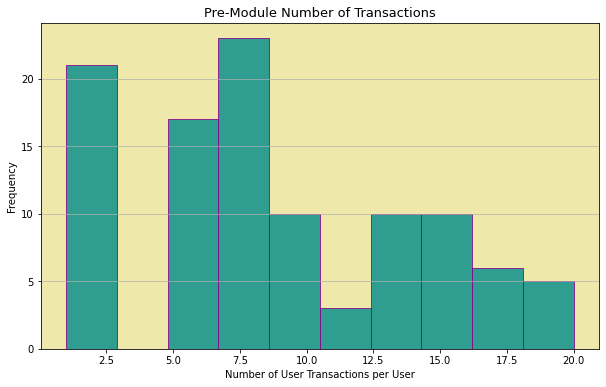

In [39]:
x1 = df_pre['user_id'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(x1, color='#008B8B', edgecolor = '#8B008B', alpha=0.8)
plt.title('Pre-Module Number of Transactions', size = 13)
plt.xlabel('Number of User Transactions per User')
plt.ylabel('Frequency')

plt.grid(axis='y', alpha=0.85)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax = plt.gca()
ax.set_facecolor('#EEE8AA')

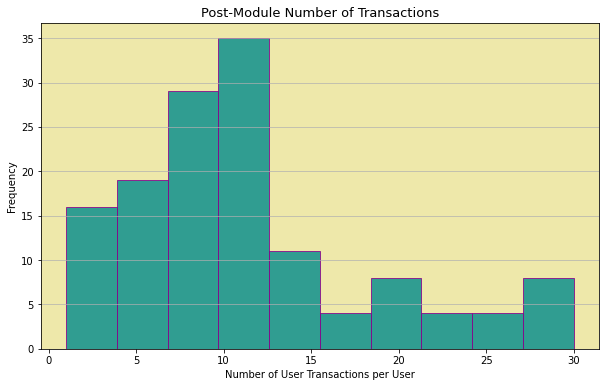

In [40]:
x2 = df_post['user_id'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(x2, color='#008B8B', edgecolor = '#8B008B', alpha=0.8)
plt.title('Post-Module Number of Transactions', size = 13)
plt.xlabel('Number of User Transactions per User')
plt.ylabel('Frequency')

plt.grid(axis='y', alpha=0.85)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

ax = plt.gca()
ax.set_facecolor('#EEE8AA')

### 4.2 Normality Testing with Shapiro-Wilk test

Simply by examining the histograms above we can clearly see that the assumption of normality for distributions has been violated, but us actually do the statistical testing in code. Let us check again for normality (i.e. normal distribution) using the Shapiro-Wilk test.

In [41]:
x1 = df_pre['user_id'].value_counts()
x2 = df_post['user_id'].value_counts()

In [42]:
# Shapiro-Wilk test for normality

# Pre-Module group
stat, p = stats.shapiro(x1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('We fail to reject the Null Hypothesis H0 of the Shapiro-Wilk test. \nThis means that the distribution of the pre-module group sample appears to be Gaussian ')
else:
    print('We reject the Null Hypothesis of the Shapiro-Wilk test. \nThis means that the distribution of pre-module group does not look Gaussian')
    
# For second group
stat, p = stats.shapiro(x2)
print('\nStatistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('We fail to reject the Null Hypothesis H0 of the Shapiro-Wilk test. \nThis means that the distribution of the post-module group sample appears to be Gaussian ')
else:
    print('We reject the Null Hypothesis of the Shapiro-Wilk test. \nThis means that the distribution of post-module group does not look Gaussian')
    

Statistics=0.926, p=0.000
We reject the Null Hypothesis of the Shapiro-Wilk test. 
This means that the distribution of pre-module group does not look Gaussian

Statistics=0.904, p=0.000
We reject the Null Hypothesis of the Shapiro-Wilk test. 
This means that the distribution of post-module group does not look Gaussian


## 4.3 Homogeneity of variance - Levene's test

**What does this mean?**

As expected, both of our groups do not have a normal distribution, therefore we cannot use a student's t-test to assess whether there is any statistical significance between our two groups. Instead of a parametric t-test we will have to make due with a non-parametric test.

Next item in the agenda: testing for homogeneity of variance with Levene's test.

In [43]:
stat, p = stats.levene(x1, x2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Variances between pre-module and post-module groups are equal: we fail to reject the Null Hypothesis of Levene''s test)')
else:
    print('Variances between pre-module and post-module groups are not equal: we reject the Null Hypothesis of Levene''s test)')

Statistics=2.210, p=0.138
Variances between pre-module and post-module groups are equal: we fail to reject the Null Hypothesis of Levenes test)


**What does this mean?**

Since the variances between our two groups are equal in Levene's test this means that we can use the Mann-Whitney U test which is relatively robust.

If the above test also failed and the variances where not equal in Levene's test we would have to choose another non-parametric test like Welch's t-test, which does not assume equal variances.

In [44]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U for significance testing

stat, p = mannwhitneyu(x1, x2)
alpha = 0.05
if p > alpha:
    print('We fail to reject the Null Hypothesis of the Mann-Whitney U test. \nThis means that there is no significant difference between the pre-module and post-module groups.')
else:
    print('We reject the Null Hypothesis of the Mann-Whitney U test. \nThis means that there is significant difference between the pre-module and post-module groups.')
    

We reject the Null Hypothesis of the Mann-Whitney U test. 
This means that there is significant difference between the pre-module and post-module groups.


Our analysis is completed.

We performed a mandatory exploratory data analysis, uncovered a prevalent issue in our hypothetical application, constructed an extensive methodology, outlined our key choices step by step, clearly stated the theory and hypotheses setting, and performed statistical testing proving that there are no statistically significant results between the introduction of the new modules and the pre-module time period. As such, we may construct our report and assist our colleagues correct our newfound app issues.